In [1]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from itertools import combinations
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import roc_auc_score, accuracy_score, mean_squared_error, confusion_matrix, f1_score
import xgboost as xgb

from utils import SOSEncoder, TargetEncoder, EqualSplit

import warnings
warnings.filterwarnings('ignore')

## Configuration

In [2]:
DIR = 'D:\\PPrograms\\Python\\Kaggle\\Predicting Loan Pay\\'
TARGET = 'loan_paid_back'
SEED = 42
CV = 5

In [3]:
train = pd.read_csv(os.path.join(DIR, 'data\\train.csv'), index_col='id')
test = pd.read_csv(os.path.join(DIR, 'data\\test.csv'), index_col='id')

In [4]:
nvp = np.sum(train[TARGET]==0)/np.sum(train[TARGET]==1)
multi_n = round(1/nvp)
print(f'The ratio of negative sample vs positive sample is {nvp}({multi_n}).')

The ratio of negative sample vs positive sample is 0.25184723094496453(4).


In [5]:
NUM = [col for col in test.columns if train[col].dtypes in ('float64', 'int64')]
CAT = [col for col in test.columns if train[col].dtypes in ('object',)]
COL = NUM + CAT
print(f'There are {test.shape[1]} cols, in which {len(NUM)} are numerical and {len(CAT)} are categorical.')

There are 11 cols, in which 5 are numerical and 6 are categorical.


In [6]:
train, valid = train_test_split(train, test_size=0.2, random_state=SEED, stratify=train[TARGET])

## Data Equal Split

In [7]:
esplit = EqualSplit(random_state=SEED)
train, _ = esplit.fit_resample(train, train[TARGET])
print(f'Data is split into {esplit.n_split_} folds, each fold has {esplit.majority_} major samples and {esplit.minority_} minor samples.')

Data is split into 4 folds, each fold has 94898 major samples and 95600 minor samples.


In [8]:
# copy valid and test data to n_split folds
valid = [valid.copy() for _ in range(esplit.n_split_)]
test = [test.copy() for _ in range(esplit.n_split_)]

## Feature Engineering
### Frequency

In [9]:
FREQ = []


def generate_frequency_feature(df, *df_other, append=True):
    train = pd.DataFrame(index=df.index)
    other = [pd.DataFrame(index=_.index) for _ in df_other]

    for col in COL:
        # --- Ratio Features ---
        # count the ratio of occurrences of each unique values
        freq= df[col].value_counts()/df.shape[0]
        col_name = f'{col}_freq'
        train[col_name] = df[col].map(freq)
        for i in range(len(other)):
            other[i][col_name] = df_other[i][col].map(freq).fillna(freq.mean())

        if append:
            FREQ.append(col_name)
        # --- Bin Features ---
        # split the numerical col into bins
        if col in NUM:
            for q in [5, 10, 15]:
                train_bins, bins = pd.cut(df[col], bins=q, labels=False, retbins=True, duplicates="drop")
                col_name = f'{col}_bins{q}'
                train[col_name] = train_bins
                for i in range(len(other)):
                    other[i][col_name] = pd.cut(df_other[i][col], bins=bins, labels=False, duplicates="drop", include_lowest=True)

                if append:
                    FREQ.append(col_name)
    # --- Weighted Bins Features ---
    # split the numerical col into bins while label there weight
    sos = SOSEncoder(20)
    res = sos.fit_transform(df[NUM])
    train = train.join(res)
    for i in range(len(other)):
        res = sos.transform(df_other[i][NUM])
        other[i] = other[i].join(res)

    if append:
        FREQ.extend(sos.res_columns)

    # concatenate all features at once
    df = pd.concat([df, train], axis=1)
    for i in range(len(other)):
        other[i] = pd.concat([df_other[i], other[i]], axis=1)
    return df, *other


for i, data in enumerate(train):
    train[i], valid[i], test[i] = generate_frequency_feature(data, *[valid[i], test[i]], append=(i==0))
print(f'{len(FREQ)} Frequency features created.')

136 Frequency features created.


### Subgrade

In [10]:
SUBGRADE = []

def generate_subgrade_feature(df, *df_other, append=True):
    grade_map = {
        'A': 0,
        'B': 1,
        'C': 2,
        'D': 3,
        'E': 4,
        'F': 5,
    }

    df['ordered_grade'] = df['grade_subgrade'].str[0].map(grade_map)
    df['subgrade'] = df['grade_subgrade'].str[1:].astype(int)
    for data in df_other:
        data['ordered_grade'] = data['grade_subgrade'].str[0].map(grade_map)
        data['subgrade'] = data['grade_subgrade'].str[1:].astype(int)
    if append:
        SUBGRADE.append('ordered_grade')
        SUBGRADE.append('subgrade')

    return df, *df_other

for i, data in enumerate(train):
    train[i], valid[i], test[i] = generate_subgrade_feature(data, *[valid[i], test[i]], append=(i==0))
print(f'{len(SUBGRADE)} Subgrade features created.')

2 Subgrade features created.


### OrdCategory

In [11]:
ORDCATE = []
def generate_ordcategory_feature(df, *df_other, append=True):
    edu_map = {
        "Other": 0,
        "High School": 1,
        "Bachelor's": 2,
        "Master's": 3,
        "PhD": 4,
    }
    emp_map = {
        'Unemployed': 0,
        'Student': 1,
        'Self-employed': 2,
        'Employed': 3,
        'Retired': 4,
    }
    for data in [df, *df_other]:
        data['ordered_edu_level'] = data['education_level'].map(edu_map)
        data['ordered_employment_status'] = data['employment_status'].map(emp_map)
    if append:
        ORDCATE.append('ordered_edu_level')
        ORDCATE.append('ordered_employment_status')

    return df, *df_other

for i, data in enumerate(train):
    train[i], valid[i], test[i] = generate_ordcategory_feature(data, *[valid[i], test[i]], append=(i==0))
print(f'{len(ORDCATE)} Ordcategory features created.')

2 Ordcategory features created.


### Quadratic

In [13]:
INTER = []

def generate_quadratic_feature(df, *df_other, append=True):
    # values of fea 'annual_income' and 'loan_amount' are too much ,and they are not important in statistics in the meantime
    quadra_cols = combinations([col for col in COL if col not in ('annual_income', 'loan_amount')], 2)
    for col1, col2 in quadra_cols:
        col = f'{col1}_{col2}'
        for data in [df, *df_other]:
            data[col] = data[col1].astype(str) + '_' + data[col2].astype(str)
            data[col] = data[col].astype('category')
        if append:
            INTER.append(col)

    return df, *df_other

for i, data in enumerate(train):
    train[i], test[i], valid[i] = generate_quadratic_feature(train[i], test[i], valid[i], append=(i==0))
print(f'{len(INTER)} Inter features created.')

36 Inter features created.


### Round

In [14]:
ROUND = []

def generate_round_feature(df, *df_other, append=True):
    rounding_levels = {
        '1r': 0,
        '10r': -1,
        '100r': -2
    }
    for col in ['annual_income', 'loan_amount']:
        for suffix, level in rounding_levels.items():
            col_name = f'{col}_{suffix}'
            for data in [df, *df_other]:
                data[col_name] = data[col].round(level).astype(int)

            if append:
                ROUND.append(col_name)
    return df, *df_other

for i, data in enumerate(train):
    train[i], valid[i], test[i] = generate_round_feature(data, *[valid[i], test[i]], append=(i==0))
print(f'{len(ROUND)} Round features created.')

6 Round features created.


### Target

In [15]:
TAR = []

def generate_target_feature(df, *df_other, append=True):
    tar = TargetEncoder(cols_to_encode=COL, aggs=['mean'], drop_original=True)
    other = list(df_other)

    df_tar = tar.fit_transform(df[COL], df[TARGET])
    df = df.join(df_tar)
    for i in range(len(other)):
        other[i] = other[i].join(tar.transform(other[i][COL]))
    if append:
        TAR.extend(df_tar.columns)

    return df, *other

for i, data in enumerate(train):
    train[i], valid[i], test[i] = generate_target_feature(data, *[valid[i], test[i]], append=(i==0))
print(f'{len(TAR)} Target features created.')

11 Target features created.


In [16]:
for col in CAT:
    for i, data in enumerate(train):
        train[i][col] = train[i][col].astype('category')
        test[i][col] = test[i][col].astype('category')
        valid[i][col] = valid[i][col].astype('category')

In [17]:
FEATURES = CAT + NUM + TAR + ROUND + SUBGRADE + FREQ + ORDCATE
print(len(FEATURES), 'Features.')

168 Features.


## Feature Select

In [20]:
base_feas_select = []

In [23]:
def multi_dataset_xgg_feature_test(X_set, y_set, X_cols=None ,cv=5, seed=42, **kwargs):
    res = {
        'auc': [],
        'acc': [],
        'rmse': [],
    }

    # Judge the model type(classification or regression)
    cls_model = True if 'eval_metric' not in kwargs or kwargs['eval_metric']=='auc' else False

    for i, X in enumerate(X_set):
        if type(y_set) is str:
            y = X[y_set]
        else:
            y = y_set[i]
        if X_cols is not None:
            X = X[X_cols]
        print(f"\n{'#'*25}")
        print(f"### BATCH : {i+1} ###")
        print(f"{'#'*25}\n")

        ret = xgg_feature_test(X, y, cv=cv, seed=seed, **kwargs)

        print(f'\n{"+"*25}')
        if cls_model:
            print(f"BATCH{i+1} MEAN AUC: {ret[0]:.5f}, ACC: {ret[1]:.5f}")
            res['auc'].append(ret[0])
            res['acc'].append(ret[1])
        else:
            print(f"BATCH{i+1} MEAN RMSE: {ret[0]:.5f}")
            res['rmse'].append(ret[0])
        print(f'{"+"*25}\n')

    print(f'\n{"="*50}')
    if cls_model:
        print(f"BATCH MEAN AUC = {np.mean(res['auc']):.5f}, ACC = {np.mean(res['acc']):.5f}")
        ret = (np.mean(res['auc']), np.mean(res['acc']))
    else:
        print(f"BATCH MEAN RMSE = {np.mean(res['rmse']):.5f}")
        ret = (np.mean(res['rmse']),)
    print(f'{"="*50}')

    return ret

In [24]:
def xgg_feature_test(X, y, cv=5, seed=42, **kwargs):
    kf = KFold(n_splits=cv, shuffle=True, random_state=seed)

    params = {
        'booster':'gbtree',
        'eval_metric': 'auc',
        "objective": "binary:logistic",
        "tree_method": "hist",
        "device": "cuda",
        'seed':seed,
    }

    params.update(kwargs)

    res = {
        'auc': [],
        'acc': [],
        'rmse': [],
    }
    for FOLD, (train_idx, val_idx) in enumerate(kf.split(X, y)):

        print(f"\n{'-'*20}")
        print(f"{'-'*5} FOLD : {FOLD+1} {'-'*5}")
        print(f"{'-'*20}")

        x_train = X.iloc[train_idx].copy()
        y_train = y.iloc[train_idx].copy()
        x_val = X.iloc[val_idx].copy()
        y_val = y.iloc[val_idx].copy()

        dtrain = xgb.DMatrix(x_train, label=y_train, enable_categorical=True)
        dval = xgb.DMatrix(x_val, label=y_val, enable_categorical=True)

        model = xgb.train(
            params=params,
            dtrain=dtrain,
            num_boost_round=10000,
            evals=[(dtrain, "train"), (dval, "valid")],
            early_stopping_rounds=200,
            verbose_eval=1000
        )

        y_pred_proba = model.predict(dval)
        if params['eval_metric'] == 'auc':
            # auc
            fold_auc = roc_auc_score(y_val, y_pred_proba)
            res['auc'].append(fold_auc)
            # acc
            y_pred = (y_pred_proba > 0.5).astype(int)  # 以0.5为阈值将概率转换为0/1标签
            fold_accuracy = accuracy_score(y_val, y_pred)
            res['acc'].append(fold_accuracy)
            print(f"FOLD {FOLD+1} AUC: {fold_auc:.5f} ACC: {fold_accuracy:.5f}")
        else:
            # rmse
            fold_rmse = mean_squared_error(y_val, y_pred_proba)
            res['rmse'].append(fold_rmse)
            print(f"FOLD {FOLD+1} RMSE: {fold_rmse:.5f}")

    if params['eval_metric'] == 'auc':
        ret = (np.mean(res['auc']), np.mean(res['acc']))
    else:
        ret = (np.mean(res['rmse']),)

    return ret

In [23]:
base_feas_select.append(('RAW', multi_dataset_xgg_feature_test(train, TARGET, COL, cv=CV, seed=SEED)))


#########################
### BATCH : 1 ###
#########################


--------------------
----- FOLD : 1 -----
--------------------
[0]	train-auc:0.91013	valid-auc:0.91013
[275]	train-auc:0.96322	valid-auc:0.91593
FOLD 1 AUC: 0.91594 ACC: 0.83097

--------------------
----- FOLD : 2 -----
--------------------
[0]	train-auc:0.91026	valid-auc:0.91046
[255]	train-auc:0.96125	valid-auc:0.91676
FOLD 2 AUC: 0.91675 ACC: 0.83370

--------------------
----- FOLD : 3 -----
--------------------
[0]	train-auc:0.91065	valid-auc:0.90894
[261]	train-auc:0.96156	valid-auc:0.91453
FOLD 3 AUC: 0.91449 ACC: 0.83045

--------------------
----- FOLD : 4 -----
--------------------
[0]	train-auc:0.91039	valid-auc:0.90815
[279]	train-auc:0.96319	valid-auc:0.91324
FOLD 4 AUC: 0.91318 ACC: 0.83102

--------------------
----- FOLD : 5 -----
--------------------
[0]	train-auc:0.91053	valid-auc:0.90980
[288]	train-auc:0.96380	valid-auc:0.91410
FOLD 5 AUC: 0.91409 ACC: 0.83076

+++++++++++++++++++++++++
BATCH1

In [24]:
base_feas_select.append(('FREQ', multi_dataset_xgg_feature_test(train, TARGET, COL+FREQ, cv=CV, seed=SEED)))


#########################
### BATCH : 1 ###
#########################


--------------------
----- FOLD : 1 -----
--------------------
[0]	train-auc:0.91128	valid-auc:0.91056
[252]	train-auc:0.96732	valid-auc:0.91841
FOLD 1 AUC: 0.91835 ACC: 0.83509

--------------------
----- FOLD : 2 -----
--------------------
[0]	train-auc:0.91118	valid-auc:0.91111
[257]	train-auc:0.96785	valid-auc:0.91792
FOLD 2 AUC: 0.91792 ACC: 0.83507

--------------------
----- FOLD : 3 -----
--------------------
[0]	train-auc:0.91142	valid-auc:0.90924
[259]	train-auc:0.96699	valid-auc:0.91706
FOLD 3 AUC: 0.91706 ACC: 0.83367

--------------------
----- FOLD : 4 -----
--------------------
[0]	train-auc:0.91164	valid-auc:0.90927
[238]	train-auc:0.96575	valid-auc:0.91575
FOLD 4 AUC: 0.91575 ACC: 0.83294

--------------------
----- FOLD : 5 -----
--------------------
[0]	train-auc:0.91165	valid-auc:0.91071
[246]	train-auc:0.96609	valid-auc:0.91649
FOLD 5 AUC: 0.91652 ACC: 0.83385

+++++++++++++++++++++++++
BATCH1

In [25]:
base_feas_select.append(('ORDER', multi_dataset_xgg_feature_test(train, TARGET, COL+ORDCATE, cv=CV, seed=SEED)))


#########################
### BATCH : 1 ###
#########################


--------------------
----- FOLD : 1 -----
--------------------
[0]	train-auc:0.91013	valid-auc:0.91013
[263]	train-auc:0.96185	valid-auc:0.91631
FOLD 1 AUC: 0.91631 ACC: 0.83286

--------------------
----- FOLD : 2 -----
--------------------
[0]	train-auc:0.91026	valid-auc:0.91046
[257]	train-auc:0.96069	valid-auc:0.91658
FOLD 2 AUC: 0.91658 ACC: 0.83228

--------------------
----- FOLD : 3 -----
--------------------
[0]	train-auc:0.91065	valid-auc:0.90894
[273]	train-auc:0.96340	valid-auc:0.91418
FOLD 3 AUC: 0.91415 ACC: 0.82871

--------------------
----- FOLD : 4 -----
--------------------
[0]	train-auc:0.91039	valid-auc:0.90815
[274]	train-auc:0.96313	valid-auc:0.91328
FOLD 4 AUC: 0.91328 ACC: 0.83042

--------------------
----- FOLD : 5 -----
--------------------
[0]	train-auc:0.91053	valid-auc:0.90980
[244]	train-auc:0.96073	valid-auc:0.91478
FOLD 5 AUC: 0.91478 ACC: 0.83112

+++++++++++++++++++++++++
BATCH1

In [26]:
base_feas_select.append(('ROUND', multi_dataset_xgg_feature_test(train, TARGET, COL+ROUND, cv=CV, seed=SEED)))


#########################
### BATCH : 1 ###
#########################


--------------------
----- FOLD : 1 -----
--------------------
[0]	train-auc:0.91013	valid-auc:0.91013
[251]	train-auc:0.96098	valid-auc:0.91614
FOLD 1 AUC: 0.91615 ACC: 0.83260

--------------------
----- FOLD : 2 -----
--------------------
[0]	train-auc:0.91026	valid-auc:0.91046
[244]	train-auc:0.95962	valid-auc:0.91637
FOLD 2 AUC: 0.91637 ACC: 0.83339

--------------------
----- FOLD : 3 -----
--------------------
[0]	train-auc:0.91065	valid-auc:0.90895
[270]	train-auc:0.96276	valid-auc:0.91400
FOLD 3 AUC: 0.91400 ACC: 0.83181

--------------------
----- FOLD : 4 -----
--------------------
[0]	train-auc:0.91039	valid-auc:0.90815
[270]	train-auc:0.96279	valid-auc:0.91313
FOLD 4 AUC: 0.91313 ACC: 0.82994

--------------------
----- FOLD : 5 -----
--------------------
[0]	train-auc:0.91053	valid-auc:0.90980
[269]	train-auc:0.96268	valid-auc:0.91452
FOLD 5 AUC: 0.91452 ACC: 0.83257

+++++++++++++++++++++++++
BATCH1

In [28]:
base_feas_select.append(('SUBGRADE', multi_dataset_xgg_feature_test(train, TARGET, COL+SUBGRADE, cv=CV, seed=SEED)))


#########################
### BATCH : 1 ###
#########################


--------------------
----- FOLD : 1 -----
--------------------
[0]	train-auc:0.91013	valid-auc:0.91013
[277]	train-auc:0.96286	valid-auc:0.91586
FOLD 1 AUC: 0.91586 ACC: 0.83084

--------------------
----- FOLD : 2 -----
--------------------
[0]	train-auc:0.91026	valid-auc:0.91046
[259]	train-auc:0.96144	valid-auc:0.91613
FOLD 2 AUC: 0.91614 ACC: 0.83415

--------------------
----- FOLD : 3 -----
--------------------
[0]	train-auc:0.91065	valid-auc:0.90894
[261]	train-auc:0.96125	valid-auc:0.91399
FOLD 3 AUC: 0.91399 ACC: 0.82900

--------------------
----- FOLD : 4 -----
--------------------
[0]	train-auc:0.91039	valid-auc:0.90815
[261]	train-auc:0.96169	valid-auc:0.91351
FOLD 4 AUC: 0.91351 ACC: 0.83005

--------------------
----- FOLD : 5 -----
--------------------
[0]	train-auc:0.91053	valid-auc:0.90980
[287]	train-auc:0.96470	valid-auc:0.91400
FOLD 5 AUC: 0.91394 ACC: 0.83107

+++++++++++++++++++++++++
BATCH1

In [29]:
base_feas_select.append(('TAR', multi_dataset_xgg_feature_test(train, TARGET, COL+TAR, cv=CV, seed=SEED)))


#########################
### BATCH : 1 ###
#########################


--------------------
----- FOLD : 1 -----
--------------------
[0]	train-auc:0.91800	valid-auc:0.91783
[230]	train-auc:0.96735	valid-auc:0.91899
FOLD 1 AUC: 0.91894 ACC: 0.83488

--------------------
----- FOLD : 2 -----
--------------------
[0]	train-auc:0.91794	valid-auc:0.91718
[235]	train-auc:0.96755	valid-auc:0.91976
FOLD 2 AUC: 0.91976 ACC: 0.83772

--------------------
----- FOLD : 3 -----
--------------------
[0]	train-auc:0.91830	valid-auc:0.91589
[223]	train-auc:0.96632	valid-auc:0.91767
FOLD 3 AUC: 0.91762 ACC: 0.83543

--------------------
----- FOLD : 4 -----
--------------------
[0]	train-auc:0.91821	valid-auc:0.91556
[224]	train-auc:0.96560	valid-auc:0.91838
FOLD 4 AUC: 0.91835 ACC: 0.83582

--------------------
----- FOLD : 5 -----
--------------------
[0]	train-auc:0.91798	valid-auc:0.91732
[225]	train-auc:0.96624	valid-auc:0.91846
FOLD 5 AUC: 0.91843 ACC: 0.83587

+++++++++++++++++++++++++
BATCH1

In [30]:
base_feas_select.sort(key=lambda x: x[1][0], reverse=True)
print('#'*25)
print('### feature selection rank ###')
print(f"{'#'*25}\n")
for i, (fea, (auc, acc)) in enumerate(base_feas_select):
    print(f'{i+1} {fea} AUC: {auc:.5f} ACC: {acc:.5f}')

#########################
### feature selection rank ###
#########################

1 TAR AUC: 0.91893 ACC: 0.83674
2 FREQ AUC: 0.91760 ACC: 0.83496
3 ROUND AUC: 0.91534 ACC: 0.83211
4 ORDER AUC: 0.91531 ACC: 0.83219
5 RAW AUC: 0.91530 ACC: 0.83196
6 SUBGRADE AUC: 0.91522 ACC: 0.83183


## BASE MODEL

In [25]:
import optuna

def objective(trial, X_set, y_true_set, y_pred_prev, X_cols, n_splits=5, seed=42):
    """
    Objective for Optuna that tunes residual-based XGBoost using 5-fold CV.
    Evaluates RMSE on actual target (not residuals).

    Parameters
    ----------
    X : List of pd.DataFrame or np.ndarray
        Feature matrix
    y_true : List of np.ndarray or target column
        True target values
    y_pred_prev : List of np.ndarray or None
        Previous model predictions (for residual correction)
    n_splits : int
        Number of CV folds
    """

    # Judge the type of model (base or residual), then select different objective function and eval metric
    if y_pred_prev is None:
        obj = "binary:logistic"
        eval_metric = 'auc'
    else:
        obj = "reg:squarederror"
        eval_metric = "rmse"

    # --- Hyperparameter search space ---
    param = {
        "objective": obj,
        "eval_metric": eval_metric,
        "tree_method": "hist",
        "device": "cuda",
        'booster': 'gbtree',
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "min_child_weight": trial.suggest_float("min_child_weight", 1, 15),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 2.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.5, 5.0, log=True),
        "gamma": trial.suggest_float("gamma", 0.0, 5.0),
        "max_leaves": trial.suggest_int("max_leaves", 4, 32),
    }

    # use a small learning_rate when construct residual model
    if y_pred_prev is not None:
        param.update({
            "learning_rate": 0.005,
        })
    else:
        y_pred_prev = [pd.Series(data=np.zeros(X_set[i].shape[0]), index=X_set[i].index) for i in range(len(X_set))]
        param.update({
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.15),
        })

    # --- 5-Fold CV ---
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=seed)

    auc_scores = []
    for i, X in enumerate(X_set):
        if type(y_true_set) is str:
            y_true = X[y_true_set]
        else:
            y_true = y_true_set[i]
        if X_cols is not None:
            X = X[X_cols]
        # Calculate residual
        y_resid = y_true - y_pred_prev[i]

        auc_scores_fold = []
        for fold, (train_idx, valid_idx) in enumerate(kf.split(X)):
            X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
            y_resid_train, y_resid_valid = y_resid.iloc[train_idx], y_resid.iloc[valid_idx]


            dtrain = xgb.DMatrix(X_train, label=y_resid_train, enable_categorical=True)
            dvalid = xgb.DMatrix(X_valid, label=y_resid_valid, enable_categorical=True)

            # Train residual model
            model = xgb.train(
                params=param,
                dtrain=dtrain,
                num_boost_round=10000 if y_pred_prev is None else 3000,
                evals=[(dtrain, "train"), (dvalid, "valid")],
                early_stopping_rounds=100 if y_pred_prev is None else 10000,
                verbose_eval=False,
            )

            # Predict probs
            preds = model.predict(dvalid, iteration_range=(0, model.best_iteration + 1))

            # integrate model predictions
            preds_proba = np.clip(preds + y_pred_prev[i].iloc[valid_idx], 0, 1)

            # auc
            fold_auc = roc_auc_score(y_true.iloc[valid_idx], (preds_proba > 0.5).astype(int))
            auc_scores_fold.append(fold_auc)

        auc_scores.append(np.mean(auc_scores_fold))

    # --- Aggregate fold scores ---
    mean_auc = np.mean(auc_scores)
    print(f"Trial {trial.number}: CV AUC = {mean_auc:.5f}")

    # Optuna minimizes AUC ACC directly
    return mean_auc


def tune_xgb_with_optuna(X_set, y_true_set, y_pred_prev=None, X_cols=None, n_trials=10, timeout=3600, n_splits=5, seed=42):
    """
    Run Optuna hyperparameter tuning with 5-fold CV.
    """

    print(f"Starting Optuna tuning with {n_splits}-fold CV on residuals...")
    study = optuna.create_study(direction="maximize", study_name="xgb_cv_tuning")
    study.optimize(
        lambda trial: objective(trial, X_set, y_true_set, y_pred_prev, X_cols, n_splits=n_splits, seed=seed),
        n_trials=n_trials,
        timeout=timeout,
        show_progress_bar=True
    )

    # --- Report best result ---
    trial = study.best_trial
    print("\nBest trial summary:")
    print(f"  • Best AUC: {trial.value:.6f}")
    print(f"  • Best parameters: {trial.params}")
    return trial.params, trial.value

In [32]:
base_param = tune_xgb_with_optuna(train, TARGET, X_cols=COL+ROUND+SUBGRADE+ORDCATE+FREQ+TAR,seed=SEED)

[I 2025-11-17 10:02:41,892] A new study created in memory with name: xgb_cv_tuning


Starting Optuna tuning with 5-fold CV on residuals...


Best trial: 0. Best value: 0.843907:  10%|█         | 1/10 [07:19<1:05:55, 439.47s/it, 439.47/3600 seconds]

Trial 0: CV AUC = 0.84391
[I 2025-11-17 10:10:01,357] Trial 0 finished with value: 0.8439073998247686 and parameters: {'max_depth': 3, 'min_child_weight': 10.188862129790596, 'subsample': 0.6248293247280393, 'colsample_bytree': 0.8552642974969467, 'reg_alpha': 1.193890110452463, 'reg_lambda': 0.6074631343795132, 'gamma': 1.3847482097823853, 'max_leaves': 15, 'learning_rate': 0.10517681627928248}. Best is trial 0 with value: 0.8439073998247686.


Best trial: 0. Best value: 0.843907:  20%|██        | 2/10 [14:50<59:31, 446.40s/it, 890.71/3600 seconds]  

Trial 1: CV AUC = 0.84380
[I 2025-11-17 10:17:32,609] Trial 1 finished with value: 0.8437950293810587 and parameters: {'max_depth': 5, 'min_child_weight': 5.38114086416139, 'subsample': 0.7774773786579912, 'colsample_bytree': 0.7397608492953733, 'reg_alpha': 0.4328683883407751, 'reg_lambda': 0.9633280475090487, 'gamma': 4.045045859273921, 'max_leaves': 32, 'learning_rate': 0.0401865517631515}. Best is trial 0 with value: 0.8439073998247686.


Best trial: 0. Best value: 0.843907:  30%|███       | 3/10 [21:21<49:06, 421.00s/it, 1281.49/3600 seconds]

Trial 2: CV AUC = 0.84378
[I 2025-11-17 10:24:03,390] Trial 2 finished with value: 0.8437778970726311 and parameters: {'max_depth': 7, 'min_child_weight': 13.849718447788126, 'subsample': 0.8518846685656863, 'colsample_bytree': 0.9807976782942129, 'reg_alpha': 1.2229317254718597, 'reg_lambda': 0.9222096501135552, 'gamma': 3.567348759047739, 'max_leaves': 7, 'learning_rate': 0.14662458530395528}. Best is trial 0 with value: 0.8439073998247686.


Best trial: 0. Best value: 0.843907:  40%|████      | 4/10 [31:31<49:34, 495.78s/it, 1891.92/3600 seconds]

Trial 3: CV AUC = 0.84357
[I 2025-11-17 10:34:13,812] Trial 3 finished with value: 0.8435717644781733 and parameters: {'max_depth': 6, 'min_child_weight': 12.555787163890356, 'subsample': 0.6121729478853035, 'colsample_bytree': 0.8946943006960975, 'reg_alpha': 0.6714456812315659, 'reg_lambda': 0.503018646742403, 'gamma': 3.9536947579656436, 'max_leaves': 22, 'learning_rate': 0.11712916548772667}. Best is trial 0 with value: 0.8439073998247686.


Best trial: 0. Best value: 0.843907:  50%|█████     | 5/10 [39:49<41:22, 496.43s/it, 2389.49/3600 seconds]

Trial 4: CV AUC = 0.84378
[I 2025-11-17 10:42:31,377] Trial 4 finished with value: 0.8437794977196619 and parameters: {'max_depth': 4, 'min_child_weight': 7.160850795182861, 'subsample': 0.8536305585178614, 'colsample_bytree': 0.7882420205055918, 'reg_alpha': 1.2186655602318355, 'reg_lambda': 1.8323238746044355, 'gamma': 3.7477742130395395, 'max_leaves': 12, 'learning_rate': 0.022752333274510542}. Best is trial 0 with value: 0.8439073998247686.


Best trial: 0. Best value: 0.843907:  60%|██████    | 6/10 [47:56<32:52, 493.24s/it, 2876.53/3600 seconds]

Trial 5: CV AUC = 0.84376
[I 2025-11-17 10:50:38,419] Trial 5 finished with value: 0.8437599956140902 and parameters: {'max_depth': 3, 'min_child_weight': 2.707838503566471, 'subsample': 0.8430879120828274, 'colsample_bytree': 0.7319226712400375, 'reg_alpha': 1.7125802789040874, 'reg_lambda': 0.5042966635733501, 'gamma': 1.9320055107131484, 'max_leaves': 31, 'learning_rate': 0.13439318412525975}. Best is trial 0 with value: 0.8439073998247686.


Best trial: 0. Best value: 0.843907:  70%|███████   | 7/10 [54:55<23:27, 469.04s/it, 3295.75/3600 seconds]

Trial 6: CV AUC = 0.84389
[I 2025-11-17 10:57:37,641] Trial 6 finished with value: 0.843894815388477 and parameters: {'max_depth': 4, 'min_child_weight': 13.193333469813378, 'subsample': 0.8373556035349805, 'colsample_bytree': 0.9663170322950893, 'reg_alpha': 1.0157946741087671, 'reg_lambda': 1.2527681582080297, 'gamma': 4.391914576463943, 'max_leaves': 32, 'learning_rate': 0.12255248887909156}. Best is trial 0 with value: 0.8439073998247686.


Best trial: 0. Best value: 0.843907:  80%|████████  | 8/10 [1:03:54<15:58, 479.28s/it, 3834.20/3600 seconds]

Trial 7: CV AUC = 0.84388
[I 2025-11-17 11:06:36,083] Trial 7 finished with value: 0.8438813382792606 and parameters: {'max_depth': 6, 'min_child_weight': 14.075435209293266, 'subsample': 0.8869310130720913, 'colsample_bytree': 0.8386145822684866, 'reg_alpha': 0.5464262094530279, 'reg_lambda': 2.8062328992925774, 'gamma': 1.606046380572899, 'max_leaves': 14, 'learning_rate': 0.09565153886081475}. Best is trial 0 with value: 0.8439073998247686.

Best trial summary:
  • Best AUC: 0.843907
  • Best parameters: {'max_depth': 3, 'min_child_weight': 10.188862129790596, 'subsample': 0.6248293247280393, 'colsample_bytree': 0.8552642974969467, 'reg_alpha': 1.193890110452463, 'reg_lambda': 0.6074631343795132, 'gamma': 1.3847482097823853, 'max_leaves': 15, 'learning_rate': 0.10517681627928248}


In [33]:
# Save base model params
with open(os.path.join(DIR, 'model\\multi_machine_resp\\base_param.json'), 'w') as f:
    json.dump(base_param[0], f, indent=4)

In [93]:
with open(os.path.join(DIR, 'model\\multi_machine_resp\\base_param.json'), 'r') as f:
    param = json.load(f)

param.update({
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "tree_method": "hist",
    "device": "cuda",
    'booster': 'gbtree',
    'seed': SEED,
})

cv=5
used_feas = COL+ROUND+SUBGRADE+ORDCATE+FREQ+TAR
kf = KFold(n_splits=cv, shuffle=True, random_state=SEED)

train_fsp = [0]*len(train)
valid_fsp = np.zeros((valid[0].shape[0],len(train)))
test_fsp = np.zeros((test[0].shape[0],len(train))) # contain the predictions of test data by base model using cv
auc_batch = []
acc_batch = []
f1_batch = []
for i ,X in enumerate(train):
    train_fsp[i] = pd.Series(data=np.zeros(X.shape[0]), index=X.index)

    for fold, (train_idx, valid_idx) in enumerate(kf.split(X)):
        X_train, X_valid = X[used_feas].iloc[train_idx], X[used_feas].iloc[valid_idx]
        y_train, y_valid = X[TARGET].iloc[train_idx], X[TARGET].iloc[valid_idx]

        dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=True)
        dvalid = xgb.DMatrix(X_valid, label=y_valid, enable_categorical=True)
        dtest = xgb.DMatrix(test[i][used_feas], enable_categorical=True)
        DVALID = xgb.DMatrix(valid[i][used_feas], enable_categorical=True)

        # Train base model
        model = xgb.train(
            params=param,
            dtrain=dtrain,
            num_boost_round=10000,
            evals=[(dtrain, "train"), (dvalid, "valid")],
            early_stopping_rounds=100,
            verbose_eval=False,
        )

        # Predict probs
        valid_preds = model.predict(dvalid, iteration_range=(0, model.best_iteration + 1))
        train_fsp[i].iloc[valid_idx] = valid_preds
        test_fsp[:,i] += model.predict(dtest, iteration_range=(0, model.best_iteration + 1))
        valid_fsp[:,i] += model.predict(DVALID, iteration_range=(0, model.best_iteration + 1))
        # auc
        auc = roc_auc_score(y_valid, valid_preds)
        # acc
        y_pred = (valid_preds > 0.5).astype(int)
        acc = accuracy_score(y_valid, y_pred)
        # f1
        f1 = f1_score(y_valid, y_pred)
        print(f'Batch {i+1} Fold {fold+1} auc = {auc:.5f} acc = {acc:.5f} f1 = {f1:.5f}')

    auc_folds = roc_auc_score(train[i][TARGET], train_fsp[i])
    acc_folds = accuracy_score(train[i][TARGET], (train_fsp[i] > 0.5).astype(int))
    f1_folds = f1_score(train[i][TARGET], (train_fsp[i] > 0.5).astype(int))
    auc_batch.append(auc_folds)
    acc_batch.append(acc_folds)
    f1_batch.append(f1_folds)
    test_fsp[:,i] /= cv
    valid_fsp[:,i] /= cv
    auc_valid = roc_auc_score(valid[i][TARGET], valid_fsp[:,i])
    acc_valid = accuracy_score(valid[i][TARGET], (valid_fsp[:,i] > 0.5).astype(int))
    f1_valid = f1_score(valid[i][TARGET], (valid_fsp[:,i] > 0.5).astype(int))
    print('='*25)
    print(f'BATCH {i+1} auc = {auc_folds:.5f} acc = {acc_folds:.5f}, f1 = {f1_folds:.5f}')
    print(f'BATCH {i+1} ON VALID DATA auc = {auc_valid:.5f} acc = {acc_valid:.5f} f1 = {f1_valid:.5f}')
    print('='*25)


test_fsp_compre = np.mean(test_fsp, axis=1)
valid_fsp_compre = np.mean(valid_fsp, axis=1)
# Save test data predictions
for i, data in enumerate(train_fsp):
    data.to_csv(os.path.join(DIR, f'sub\\multi_machine_resp\\train_fsp_{i}.csv'), index=True, header=False)
pd.DataFrame(data=test_fsp, index=test[0].index).reset_index(drop=False).to_csv(os.path.join(DIR, 'sub\\multi_machine_resp\\test_resp_fsp.csv'),index=False,header=True)
pd.DataFrame(data=valid_fsp, index=valid[0].index).reset_index(drop=False).to_csv(os.path.join(DIR, 'sub\\multi_machine_resp\\valid_resp_fsp.csv'),index=False,header=True)
pd.DataFrame(data={'id': test[0].index, TARGET: test_fsp_compre}).to_csv(os.path.join(DIR, 'sub\\multi_machine_resp\\test_fsp.csv'),index=False,header=True)
pd.DataFrame(data={'id': valid[0].index, TARGET: valid_fsp_compre}).to_csv(os.path.join(DIR, 'sub\\multi_machine_resp\\valid_fsp.csv'),index=False,header=True)

print('+'*30)
print(f'BASE MODEL AUC = {np.mean(auc_batch):.5f} ACC = {np.mean(acc_batch):.5f} F1 = {np.mean(f1_batch):.5f}.')
print(f'BASE MODEL ON VALID DATA AUC = {roc_auc_score(valid[0][TARGET], valid_fsp_compre)} ACC = {accuracy_score(valid[0][TARGET], (valid_fsp_compre>0.5).astype(int))} F1 = {f1_score(valid[0][TARGET], (valid_fsp_compre>0.5).astype(int)):.5f}')
print('+'*30)

Batch 1 Fold 1 auc = 0.92585 acc = 0.84412 f1 = 0.84926
Batch 1 Fold 2 auc = 0.92575 acc = 0.84493 f1 = 0.84996
Batch 1 Fold 3 auc = 0.92402 acc = 0.84163 f1 = 0.84698
Batch 1 Fold 4 auc = 0.92379 acc = 0.84317 f1 = 0.84887
Batch 1 Fold 5 auc = 0.92489 acc = 0.83892 f1 = 0.84256
BATCH 1 auc = 0.92473 acc = 0.84255, f1 = 0.84754
BATCH 1 ON VALID DATA auc = 0.92504 acc = 0.86801 f1 = 0.91452
Batch 2 Fold 1 auc = 0.92291 acc = 0.84126 f1 = 0.84767
Batch 2 Fold 2 auc = 0.92535 acc = 0.84362 f1 = 0.84903
Batch 2 Fold 3 auc = 0.92678 acc = 0.84535 f1 = 0.84826
Batch 2 Fold 4 auc = 0.92655 acc = 0.84525 f1 = 0.85013
Batch 2 Fold 5 auc = 0.92664 acc = 0.84441 f1 = 0.85036
BATCH 2 auc = 0.92555 acc = 0.84398, f1 = 0.84909
BATCH 2 ON VALID DATA auc = 0.92499 acc = 0.86784 f1 = 0.91439
Batch 3 Fold 1 auc = 0.92716 acc = 0.84491 f1 = 0.85064
Batch 3 Fold 2 auc = 0.92429 acc = 0.84239 f1 = 0.84773
Batch 3 Fold 3 auc = 0.92505 acc = 0.84218 f1 = 0.84780
Batch 3 Fold 4 auc = 0.92444 acc = 0.84354 f1 

混淆矩阵:
[[19260  4640]
 [11090 83809]]


Text(0.5, 1.0, 'confussion')

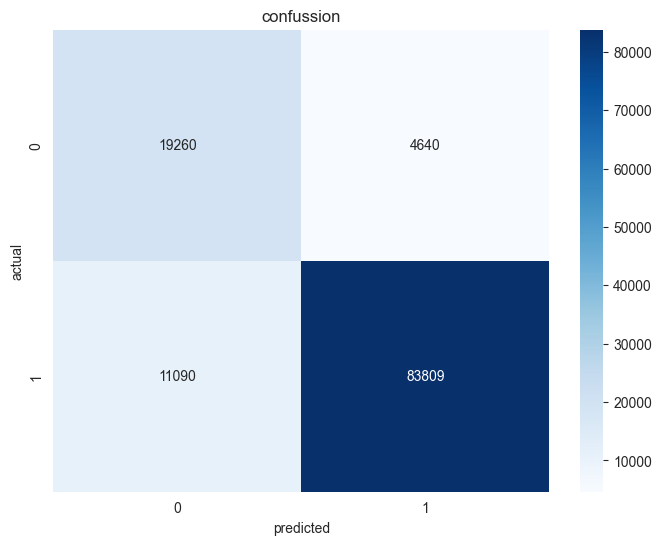

In [94]:
# 计算混淆矩阵
cm = confusion_matrix(valid[0][TARGET], (valid_fsp_compre > 0.5).astype(int))
print("混淆矩阵:")
print(cm)

# 可视化混淆矩阵
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('predicted')
plt.ylabel('actual')
plt.title('confussion')

## New Feature

In [18]:
# Add a new feature INTERTAR that contains quadratic information and is processed with TarEncoding
INTERTAR = []

def generate_inter_target_feature(df, *df_other, append=True):
    intertar = TargetEncoder(cols_to_encode=INTER, aggs=['mean', 'count'], drop_original=True)
    other = list(df_other)

    # astype category to str, later change them back
    cate_cols = [i for i, x in df.dtypes.items() if x == 'category']
    for col in cate_cols:
        df[col] = df[col].astype(str)
        for i in range(len(other)):
            other[i][col] = other[i][col].astype(str)

    df_tar = intertar.fit_transform(df[INTER], df[TARGET])
    df = df.join(df_tar)
    for i in range(len(other)):
        other[i] = other[i].join(intertar.transform(other[i][INTER]))
    if append:
        INTERTAR.extend(df_tar.columns)

    for col in cate_cols:
        df[col] = df[col].astype('category')
        for i in range(len(other)):
            other[i][col] = other[i][col].astype('category')

    return df, *other

for i, data in enumerate(train):
    train[i], test[i], valid[i] = generate_inter_target_feature(train[i], test[i], valid[i], append=(i==0))
print(f'{len(INTERTAR)} Inter Target features created.')

72 Inter Target features created.


In [19]:
# Add a new feature ROUNDAR that contains round information and is processed with TarEncoding
ROUNDTAR = []

def generate_round_target_feature(df, *df_other, append=True):
    roundtar = TargetEncoder(cols_to_encode=ROUND, aggs=['mean', 'count'], drop_original=True)
    other = list(df_other)

    df_tar = roundtar.fit_transform(df[ROUND], df[TARGET])
    df = df.join(df_tar)
    for i in range(len(other)):
        other[i] = other[i].join(roundtar.transform(other[i][ROUND]))
    if append:
        ROUNDTAR.extend(df_tar.columns)

    return df, *other

for i, data in enumerate(train):
    train[i], test[i], valid[i] = generate_round_target_feature(train[i], test[i], valid[i], append=(i==0))
print(f'{len(ROUNDTAR)} Round Target features created.')

12 Round Target features created.


## RESIDUAL MODEL

In [20]:
train_fsp = [pd.read_csv(os.path.join(DIR, f'sub\\multi_machine_resp\\train_fsp_{i}.csv'), header=None, index_col=0).loc[:, 1] for i in range(multi_n)]
resid = [train[i][TARGET] - train_fsp[i] for i in range(multi_n)]

In [21]:
cv = 5
resid_feas_select = []

In [26]:
resid_feas_select.append(('RAW', multi_dataset_xgg_feature_test(train, resid, COL, cv=cv, eval_metric='rmse', objective='reg:squarederror')))


#########################
### BATCH : 1 ###
#########################


--------------------
----- FOLD : 1 -----
--------------------
[0]	train-rmse:0.33020	valid-rmse:0.32935
[199]	train-rmse:0.29623	valid-rmse:0.33664
FOLD 1 RMSE: 0.11335

--------------------
----- FOLD : 2 -----
--------------------
[0]	train-rmse:0.33029	valid-rmse:0.32929
[199]	train-rmse:0.29648	valid-rmse:0.33690
FOLD 2 RMSE: 0.11352

--------------------
----- FOLD : 3 -----
--------------------
[0]	train-rmse:0.32970	valid-rmse:0.33142
[200]	train-rmse:0.29598	valid-rmse:0.33939
FOLD 3 RMSE: 0.11518

--------------------
----- FOLD : 4 -----
--------------------
[0]	train-rmse:0.32981	valid-rmse:0.33112
[199]	train-rmse:0.29602	valid-rmse:0.33876
FOLD 4 RMSE: 0.11479

--------------------
----- FOLD : 5 -----
--------------------
[0]	train-rmse:0.32982	valid-rmse:0.33100
[199]	train-rmse:0.29691	valid-rmse:0.33904
FOLD 5 RMSE: 0.11497

+++++++++++++++++++++++++
BATCH1 MEAN RMSE: 0.11436
++++++++++++++++++++

In [27]:
resid_feas_select.append(('INTERTAR', multi_dataset_xgg_feature_test(train, resid, COL+INTERTAR, cv=cv, eval_metric='rmse', objective='reg:squarederror')))


#########################
### BATCH : 1 ###
#########################


--------------------
----- FOLD : 1 -----
--------------------
[0]	train-rmse:0.32995	valid-rmse:0.32954
[201]	train-rmse:0.27464	valid-rmse:0.33889
FOLD 1 RMSE: 0.11485

--------------------
----- FOLD : 2 -----
--------------------
[0]	train-rmse:0.33003	valid-rmse:0.32926
[200]	train-rmse:0.27325	valid-rmse:0.33740
FOLD 2 RMSE: 0.11384

--------------------
----- FOLD : 3 -----
--------------------
[0]	train-rmse:0.32951	valid-rmse:0.33143
[199]	train-rmse:0.27311	valid-rmse:0.33888
FOLD 3 RMSE: 0.11488

--------------------
----- FOLD : 4 -----
--------------------
[0]	train-rmse:0.32959	valid-rmse:0.33102
[200]	train-rmse:0.27350	valid-rmse:0.33950
FOLD 4 RMSE: 0.11527

--------------------
----- FOLD : 5 -----
--------------------
[0]	train-rmse:0.32964	valid-rmse:0.33109
[199]	train-rmse:0.27430	valid-rmse:0.34157
FOLD 5 RMSE: 0.11669

+++++++++++++++++++++++++
BATCH1 MEAN RMSE: 0.11511
++++++++++++++++++++

In [28]:
resid_feas_select.append(('ROUNDTAR', multi_dataset_xgg_feature_test(train, resid, COL+ROUNDTAR, cv=cv, eval_metric='rmse', objective='reg:squarederror')))


#########################
### BATCH : 1 ###
#########################


--------------------
----- FOLD : 1 -----
--------------------
[0]	train-rmse:0.33006	valid-rmse:0.32907
[199]	train-rmse:0.28502	valid-rmse:0.33738
FOLD 1 RMSE: 0.11385

--------------------
----- FOLD : 2 -----
--------------------
[0]	train-rmse:0.33005	valid-rmse:0.32911
[199]	train-rmse:0.28438	valid-rmse:0.33723
FOLD 2 RMSE: 0.11376

--------------------
----- FOLD : 3 -----
--------------------
[0]	train-rmse:0.32951	valid-rmse:0.33125
[201]	train-rmse:0.28381	valid-rmse:0.34019
FOLD 3 RMSE: 0.11573

--------------------
----- FOLD : 4 -----
--------------------
[0]	train-rmse:0.32965	valid-rmse:0.33092
[204]	train-rmse:0.28319	valid-rmse:0.33942
FOLD 4 RMSE: 0.11521

--------------------
----- FOLD : 5 -----
--------------------
[0]	train-rmse:0.32965	valid-rmse:0.33087
[200]	train-rmse:0.28442	valid-rmse:0.33961
FOLD 5 RMSE: 0.11540

+++++++++++++++++++++++++
BATCH1 MEAN RMSE: 0.11479
++++++++++++++++++++

In [29]:
resid_feas_select.sort(key=lambda x: x[1][0])
print('#'*25)
print('### feature selection rank ###')
print(f"{'#'*25}\n")
for i, (fea, rmse) in enumerate(resid_feas_select):
    print(f'{i+1} {fea} RMSE: {rmse[0]:.5f}')

#########################
### feature selection rank ###
#########################

1 RAW RMSE: 0.11413
2 ROUNDTAR RMSE: 0.11428
3 INTERTAR RMSE: 0.11485


## RESID MODEL

In [65]:
resid_param = tune_xgb_with_optuna(train, TARGET, train_fsp, X_cols=ROUNDTAR+INTERTAR, seed=SEED)

[I 2025-11-17 12:00:21,374] A new study created in memory with name: xgb_cv_tuning


Starting Optuna tuning with 5-fold CV on residuals...


Best trial: 0. Best value: 0.843456:  10%|█         | 1/10 [03:54<35:14, 234.90s/it, 234.90/3600 seconds]

Trial 0: CV AUC = 0.84346
[I 2025-11-17 12:04:16,273] Trial 0 finished with value: 0.8434558937987551 and parameters: {'max_depth': 3, 'min_child_weight': 4.623646476144938, 'subsample': 0.7803952230703775, 'colsample_bytree': 0.9072986081376673, 'reg_alpha': 0.10159490192244824, 'reg_lambda': 1.3340745475038154, 'gamma': 4.362496315292659, 'max_leaves': 14}. Best is trial 0 with value: 0.8434558937987551.


Best trial: 1. Best value: 0.843465:  20%|██        | 2/10 [07:47<31:07, 233.40s/it, 467.25/3600 seconds]

Trial 1: CV AUC = 0.84347
[I 2025-11-17 12:08:08,626] Trial 1 finished with value: 0.8434651001385366 and parameters: {'max_depth': 3, 'min_child_weight': 6.860850959744791, 'subsample': 0.7077857748465991, 'colsample_bytree': 0.9094098296325895, 'reg_alpha': 1.4526927196540884, 'reg_lambda': 0.939579724613241, 'gamma': 4.582753243353203, 'max_leaves': 32}. Best is trial 1 with value: 0.8434651001385366.


Best trial: 1. Best value: 0.843465:  30%|███       | 3/10 [11:40<27:13, 233.40s/it, 700.65/3600 seconds]

Trial 2: CV AUC = 0.84346
[I 2025-11-17 12:12:02,020] Trial 2 finished with value: 0.8434555965846038 and parameters: {'max_depth': 6, 'min_child_weight': 5.414381360015948, 'subsample': 0.6086469987697137, 'colsample_bytree': 0.7387682498642008, 'reg_alpha': 0.961518822353493, 'reg_lambda': 3.6724369953376925, 'gamma': 3.0948527282709817, 'max_leaves': 22}. Best is trial 1 with value: 0.8434651001385366.


Best trial: 3. Best value: 0.843472:  40%|████      | 4/10 [16:26<25:23, 253.99s/it, 986.20/3600 seconds]

Trial 3: CV AUC = 0.84347
[I 2025-11-17 12:16:47,570] Trial 3 finished with value: 0.8434717744642501 and parameters: {'max_depth': 3, 'min_child_weight': 9.288336483375168, 'subsample': 0.7005676258037736, 'colsample_bytree': 0.8105202621925749, 'reg_alpha': 1.4548728700865754, 'reg_lambda': 3.028838050599078, 'gamma': 0.7998440655016748, 'max_leaves': 7}. Best is trial 3 with value: 0.8434717744642501.


Best trial: 4. Best value: 0.843479:  50%|█████     | 5/10 [20:31<20:53, 250.78s/it, 1231.29/3600 seconds]

Trial 4: CV AUC = 0.84348
[I 2025-11-17 12:20:52,667] Trial 4 finished with value: 0.8434791596332256 and parameters: {'max_depth': 10, 'min_child_weight': 5.592647636891899, 'subsample': 0.9677012958073652, 'colsample_bytree': 0.7693674034057512, 'reg_alpha': 1.5113249966324476, 'reg_lambda': 1.879721910948312, 'gamma': 0.8393396827674449, 'max_leaves': 4}. Best is trial 4 with value: 0.8434791596332256.


Best trial: 5. Best value: 0.843483:  60%|██████    | 6/10 [24:45<16:48, 252.02s/it, 1485.73/3600 seconds]

Trial 5: CV AUC = 0.84348
[I 2025-11-17 12:25:07,101] Trial 5 finished with value: 0.8434826541051206 and parameters: {'max_depth': 9, 'min_child_weight': 2.642282914348388, 'subsample': 0.8831180237426458, 'colsample_bytree': 0.6684911537484032, 'reg_alpha': 1.6414189729846678, 'reg_lambda': 0.681195458283714, 'gamma': 1.4893738597886612, 'max_leaves': 11}. Best is trial 5 with value: 0.8434826541051206.


Best trial: 5. Best value: 0.843483:  70%|███████   | 7/10 [33:58<17:30, 350.22s/it, 2038.12/3600 seconds]

Trial 6: CV AUC = 0.84347
[I 2025-11-17 12:34:19,491] Trial 6 finished with value: 0.8434692813487505 and parameters: {'max_depth': 7, 'min_child_weight': 10.015868024078985, 'subsample': 0.6682913054331305, 'colsample_bytree': 0.6961289170535845, 'reg_alpha': 1.605071962278737, 'reg_lambda': 1.898205275677389, 'gamma': 0.17051847591503855, 'max_leaves': 19}. Best is trial 5 with value: 0.8434826541051206.


Best trial: 5. Best value: 0.843483:  80%|████████  | 8/10 [38:50<11:03, 331.84s/it, 2330.62/3600 seconds]

Trial 7: CV AUC = 0.84346
[I 2025-11-17 12:39:11,986] Trial 7 finished with value: 0.8434638753366654 and parameters: {'max_depth': 8, 'min_child_weight': 13.195774450136659, 'subsample': 0.8947869650573677, 'colsample_bytree': 0.6858437880579245, 'reg_alpha': 1.2567045447433407, 'reg_lambda': 1.4832852781470278, 'gamma': 4.7466109548667, 'max_leaves': 29}. Best is trial 5 with value: 0.8434826541051206.


Best trial: 5. Best value: 0.843483:  90%|█████████ | 9/10 [43:43<05:19, 319.69s/it, 2623.57/3600 seconds]

Trial 8: CV AUC = 0.84346
[I 2025-11-17 12:44:04,935] Trial 8 finished with value: 0.8434571119844171 and parameters: {'max_depth': 7, 'min_child_weight': 8.488328449556661, 'subsample': 0.8376357534050256, 'colsample_bytree': 0.928528681397047, 'reg_alpha': 0.8812894530305964, 'reg_lambda': 2.5227243748407187, 'gamma': 3.8987511955039085, 'max_leaves': 20}. Best is trial 5 with value: 0.8434826541051206.


Best trial: 5. Best value: 0.843483: 100%|██████████| 10/10 [49:35<00:00, 297.54s/it, 2975.42/3600 seconds]

Trial 9: CV AUC = 0.84347
[I 2025-11-17 12:49:56,793] Trial 9 finished with value: 0.8434665774822712 and parameters: {'max_depth': 5, 'min_child_weight': 12.504572429036092, 'subsample': 0.6226333834413572, 'colsample_bytree': 0.8200939802910732, 'reg_alpha': 1.1229127665697272, 'reg_lambda': 1.6330647629999797, 'gamma': 0.8720393828822354, 'max_leaves': 20}. Best is trial 5 with value: 0.8434826541051206.

Best trial summary:
  • Best AUC: 0.843483
  • Best parameters: {'max_depth': 9, 'min_child_weight': 2.642282914348388, 'subsample': 0.8831180237426458, 'colsample_bytree': 0.6684911537484032, 'reg_alpha': 1.6414189729846678, 'reg_lambda': 0.681195458283714, 'gamma': 1.4893738597886612, 'max_leaves': 11}


In [68]:
# Save the residual model params
with open(os.path.join(DIR, 'model\\multi_machine_resp\\resid_label_param.json'), 'w') as f:
    json.dump(resid_param[0], f, indent=4)

In [92]:
# read the base model's predictions
pre_prev_train = [pd.read_csv(os.path.join(DIR, f'sub\\multi_machine_resp\\train_fsp_{i}.csv'), header=None, index_col=0).loc[:, 1] for i in range(multi_n)]
pre_prev_valid = pd.read_csv(os.path.join(DIR, 'sub\\multi_machine_resp\\valid_resp_fsp.csv'), index_col='id')
pre_prev_test = pd.read_csv(os.path.join(DIR, 'sub\\multi_machine_resp\\test_resp_fsp.csv'), index_col='id')
resid = [train[i][TARGET] - pre_prev_train[i] for i in range(multi_n)]

with open(os.path.join(DIR, 'model\\multi_machine_resp\\resid_label_param.json'), 'r') as f:
    param = json.load(f)
param.update({
    "objective": "reg:squarederror",
    "eval_metric": "rmse",
    "tree_method": "hist",
    "device": "cuda",
    'booster': 'gbtree',
    "learning_rate": 0.005,
    'seed': SEED,
})

cv=5
used_feas = ROUNDTAR+INTERTAR
kf = KFold(n_splits=cv, shuffle=True, random_state=SEED)

train_ssp = [0]*len(train)
valid_ssp = np.zeros((valid[0].shape[0],len(train)))
test_ssp = np.zeros((test[0].shape[0],len(train))) # contain the predictions of test data by base model using cv
auc_batch = []
acc_batch = []
f1_batch = []

for i, X in enumerate(train):
    train_ssp[i] = pd.Series(data=np.zeros(train[i].shape[0]), index=train[i].index) # contain the predictions of each batch train data

    for fold, (train_idx, valid_idx) in enumerate(kf.split(X)):
        X_train, X_valid = X[used_feas].iloc[train_idx], X[used_feas].iloc[valid_idx]
        y_train, y_valid = resid[i].iloc[train_idx], resid[i].iloc[valid_idx]

        dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=True)
        dvalid = xgb.DMatrix(X_valid, label=y_valid, enable_categorical=True)
        dtest = xgb.DMatrix(test[i][used_feas], enable_categorical=True)
        DVALID = xgb.DMatrix(valid[i][used_feas], enable_categorical=True)

        # Train base model
        model = xgb.train(
            params=param,
            dtrain=dtrain,
            num_boost_round=3000,
            evals=[(dtrain, "train"), (dvalid, "valid")],
            early_stopping_rounds=10000,
            verbose_eval=False,
        )

        # Predict probs
        valid_preds = model.predict(dvalid, iteration_range=(0, model.best_iteration + 1))
        valid_preds_proba = np.clip(valid_preds + pre_prev_train[i].iloc[valid_idx].values.flatten(), 0, 1)
        train_ssp[i].iloc[valid_idx] += valid_preds_proba
        test_ssp[:,i] += np.clip(model.predict(dtest, iteration_range=(0, model.best_iteration + 1)) + pre_prev_test.loc[:,str(i)].values.flatten(), 0, 1)
        valid_ssp[:,i] += np.clip(model.predict(DVALID, iteration_range=(0, model.best_iteration + 1)) + pre_prev_valid.loc[:,str(i)].values.flatten(), 0, 1)
        # auc
        y_true = train[i][TARGET].iloc[valid_idx]
        auc = roc_auc_score(y_true, valid_preds_proba)
        # acc
        y_pred = (valid_preds_proba > 0.5).astype(int)
        acc = accuracy_score(y_true, y_pred)
        # f1
        f1 = f1_score(y_true, y_pred)
        print(f'batch {i+1} fold {fold+1} auc = {auc:.5f} acc = {acc:.5f} f1 = {f1:.5f}')

    auc_folds = roc_auc_score(train[i][TARGET], train_ssp[i])
    acc_folds = accuracy_score(train[i][TARGET], (train_ssp[i] > 0.5).astype(int))
    f1_folds = f1_score(train[i][TARGET], (train_ssp[i] > 0.5).astype(int))
    auc_batch.append(auc_folds)
    acc_batch.append(acc_folds)
    f1_batch.append(f1_folds)
    test_ssp[:,i] /= cv
    valid_ssp[:,i] /= cv
    auc_valid = roc_auc_score(valid[i][TARGET], valid_ssp[:,i])
    acc_valid = accuracy_score(valid[i][TARGET], (valid_ssp[:,i] > 0.5).astype(int))
    f1_valid = f1_score(valid[i][TARGET], (valid_ssp[:,i] > 0.5).astype(int))
    print('='*25)
    print(f'BATCH {i+1} auc = {auc_folds:.5f} acc = {acc_folds:.5f}, f1 = {f1_folds:.5f}')
    print(f'BATCH {i+1} ON VALID DATA auc = {auc_valid:.5f} acc = {acc_valid:.5f} f1 = {f1_valid:.5f}')
    print('='*25)


test_ssp_compre = np.mean(test_ssp, axis=1)
valid_ssp_compre = np.mean(valid_ssp, axis=1)
# Save test data predictions
for i, data in enumerate(train_ssp):
    data.to_csv(os.path.join(DIR, f'sub\\multi_machine_resp\\train_ssp_{i}.csv'), index=True, header=False)
pd.DataFrame(data=test_ssp, index=test[0].index).reset_index(drop=False).to_csv(os.path.join(DIR, 'sub\\multi_machine_resp\\test_resp_ssp.csv'),index=False,header=True)
pd.DataFrame(data=valid_ssp, index=valid[0].index).reset_index(drop=False).to_csv(os.path.join(DIR, 'sub\\multi_machine_resp\\valid_resp_ssp.csv'),index=False,header=True)
pd.DataFrame(data={'id': test[0].index, TARGET: test_ssp_compre}).to_csv(os.path.join(DIR, 'sub\\multi_machine_resp\\test_ssp.csv'),index=False,header=True)
pd.DataFrame(data={'id': valid[0].index, TARGET: valid_ssp_compre}).to_csv(os.path.join(DIR, 'sub\\multi_machine_resp\\valid_ssp.csv'),index=False,header=True)

print('+'*30)
print(f'BASE MODEL AUC = {np.mean(auc_batch):.5f} ACC = {np.mean(acc_batch):.5f} F1 = {np.mean(f1_batch):.5f}.')
print(f'BASE MODEL ON VALID DATA AUC = {roc_auc_score(valid[0][TARGET], valid_ssp_compre)} ACC = {accuracy_score(valid[0][TARGET], (valid_ssp_compre>0.5).astype(int))} F1 = {f1_score(valid[0][TARGET], (valid_ssp_compre>0.5).astype(int)):.5f}')
print('+'*30)

batch 1 fold 1 auc = 0.92585 acc = 0.84409 f1 = 0.84957
batch 1 fold 2 auc = 0.92575 acc = 0.84496 f1 = 0.85023
batch 1 fold 3 auc = 0.92402 acc = 0.84163 f1 = 0.84733
batch 1 fold 4 auc = 0.92377 acc = 0.84296 f1 = 0.84884
batch 1 fold 5 auc = 0.92489 acc = 0.83892 f1 = 0.84256
BATCH 1 auc = 0.92468 acc = 0.84251, f1 = 0.84772
BATCH 1 ON VALID DATA auc = 0.92504 acc = 0.86910 f1 = 0.91531
batch 2 fold 1 auc = 0.92291 acc = 0.84142 f1 = 0.84814
batch 2 fold 2 auc = 0.92535 acc = 0.84336 f1 = 0.84909
batch 2 fold 3 auc = 0.92678 acc = 0.84538 f1 = 0.84838
batch 2 fold 4 auc = 0.92654 acc = 0.84509 f1 = 0.85026
batch 2 fold 5 auc = 0.92663 acc = 0.84448 f1 = 0.85075
BATCH 2 auc = 0.92551 acc = 0.84395, f1 = 0.84932
BATCH 2 ON VALID DATA auc = 0.92499 acc = 0.86888 f1 = 0.91516
batch 3 fold 1 auc = 0.92714 acc = 0.84499 f1 = 0.85084
batch 3 fold 2 auc = 0.92428 acc = 0.84226 f1 = 0.84779
batch 3 fold 3 auc = 0.92505 acc = 0.84265 f1 = 0.84848
batch 3 fold 4 auc = 0.92444 acc = 0.84351 f1 

混淆矩阵:
[[19216  4684]
 [10900 83999]]


Text(0.5, 1.0, 'confussion')

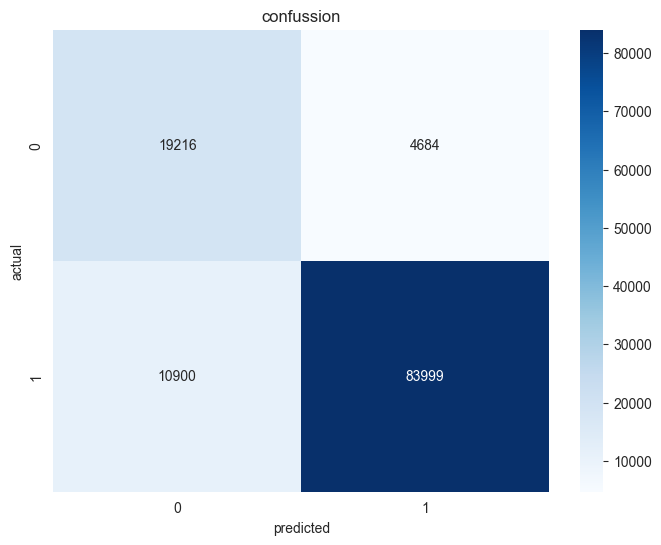

In [91]:
# 计算混淆矩阵
cm = confusion_matrix(valid[0][TARGET], (valid_ssp_compre > 0.5).astype(int))
print("混淆矩阵:")
print(cm)

# 可视化混淆矩阵
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('predicted')
plt.ylabel('actual')
plt.title('confussion')

## RESIDUAL MODEL FOR FEATURE

In [30]:
pre_prev_train = [pd.read_csv(os.path.join(DIR, f'sub\\multi_machine_resp\\train_fsp_{i}.csv'), header=None, index_col=0).loc[:, 1] for i in range(multi_n)]
pre_prev_valid = pd.read_csv(os.path.join(DIR, 'sub\\multi_machine_resp\\valid_resp_fsp.csv'), index_col='id')
pre_prev_test = pd.read_csv(os.path.join(DIR, 'sub\\multi_machine_resp\\test_resp_fsp.csv'), index_col='id')

In [32]:
# Add the logits predicted as a feature
def inv_sigmoid(X):
    return -np.log(1/X - 1)

RESID = ['RESID']

def generate_resid_feature(train, valid, test):
    for i in range(len(train)):
        train[i]['RESID'] = inv_sigmoid(pre_prev_train[i])
        valid[i]['RESID'] = inv_sigmoid(pre_prev_valid.iloc[:,i])
        test[i]['RESID'] = inv_sigmoid(pre_prev_test.iloc[:,i])

    return train, valid, test

train, valid, test = generate_resid_feature(train, valid, test)

In [34]:
resid_feature_param = tune_xgb_with_optuna(train, TARGET, X_cols=RESID+FREQ+TAR+ROUNDTAR+INTERTAR,seed=SEED)

[I 2025-11-18 22:27:16,545] A new study created in memory with name: xgb_cv_tuning


Starting Optuna tuning with 5-fold CV on residuals...


Best trial: 0. Best value: 0.844541:  10%|█         | 1/10 [07:12<1:04:50, 432.24s/it, 432.23/3600 seconds]

Trial 0: CV AUC = 0.84454
[I 2025-11-18 22:34:28,786] Trial 0 finished with value: 0.84454059938598 and parameters: {'max_depth': 5, 'min_child_weight': 13.633507192287988, 'subsample': 0.8156342775056787, 'colsample_bytree': 0.8252488376821943, 'reg_alpha': 0.3488701188902663, 'reg_lambda': 2.6514138287566102, 'gamma': 1.8060510762203719, 'max_leaves': 6, 'learning_rate': 0.13500732378078445}. Best is trial 0 with value: 0.84454059938598.


Best trial: 1. Best value: 0.84456:  20%|██        | 2/10 [15:51<1:04:26, 483.26s/it, 951.20/3600 seconds] 

Trial 1: CV AUC = 0.84456
[I 2025-11-18 22:43:07,751] Trial 1 finished with value: 0.844560342527126 and parameters: {'max_depth': 7, 'min_child_weight': 6.920470957301935, 'subsample': 0.78646221431781, 'colsample_bytree': 0.8124159663327167, 'reg_alpha': 1.9144884400369213, 'reg_lambda': 2.577981355486692, 'gamma': 1.8909845444555085, 'max_leaves': 25, 'learning_rate': 0.1213084061124868}. Best is trial 1 with value: 0.844560342527126.


Best trial: 2. Best value: 0.844591:  30%|███       | 3/10 [24:12<57:19, 491.37s/it, 1452.23/3600 seconds] 

Trial 2: CV AUC = 0.84459
[I 2025-11-18 22:51:28,772] Trial 2 finished with value: 0.844590533197697 and parameters: {'max_depth': 6, 'min_child_weight': 1.6095958938802073, 'subsample': 0.7152120384691086, 'colsample_bytree': 0.8125825493926526, 'reg_alpha': 1.869247452091156, 'reg_lambda': 0.8780250906215423, 'gamma': 0.5132851824526175, 'max_leaves': 11, 'learning_rate': 0.09572433280453509}. Best is trial 2 with value: 0.844590533197697.


Best trial: 3. Best value: 0.844707:  40%|████      | 4/10 [31:15<46:27, 464.66s/it, 1875.95/3600 seconds]

Trial 3: CV AUC = 0.84471
[I 2025-11-18 22:58:32,487] Trial 3 finished with value: 0.8447073010296993 and parameters: {'max_depth': 3, 'min_child_weight': 11.800667478055072, 'subsample': 0.8235408710396079, 'colsample_bytree': 0.8641681544772117, 'reg_alpha': 1.1002597415586175, 'reg_lambda': 1.6189881572249747, 'gamma': 2.4244875540063635, 'max_leaves': 11, 'learning_rate': 0.11814510399859923}. Best is trial 3 with value: 0.8447073010296993.


Best trial: 3. Best value: 0.844707:  50%|█████     | 5/10 [41:05<42:28, 509.69s/it, 2465.49/3600 seconds]

Trial 4: CV AUC = 0.84456
[I 2025-11-18 23:08:22,037] Trial 4 finished with value: 0.8445554891308311 and parameters: {'max_depth': 5, 'min_child_weight': 3.6591630056811106, 'subsample': 0.9535113454131661, 'colsample_bytree': 0.9001694357668498, 'reg_alpha': 1.6576272854371754, 'reg_lambda': 0.5786170244262021, 'gamma': 0.1975922678867359, 'max_leaves': 18, 'learning_rate': 0.06515058469187579}. Best is trial 3 with value: 0.8447073010296993.


Best trial: 3. Best value: 0.844707:  60%|██████    | 6/10 [47:33<31:13, 468.47s/it, 2853.94/3600 seconds]

Trial 5: CV AUC = 0.84439
[I 2025-11-18 23:14:50,484] Trial 5 finished with value: 0.8443851728468085 and parameters: {'max_depth': 7, 'min_child_weight': 11.142471148721096, 'subsample': 0.8655462063243353, 'colsample_bytree': 0.8320133094291023, 'reg_alpha': 1.6432874491944411, 'reg_lambda': 4.1446363892747815, 'gamma': 4.718992075477521, 'max_leaves': 21, 'learning_rate': 0.04302296856434397}. Best is trial 3 with value: 0.8447073010296993.


Best trial: 3. Best value: 0.844707:  70%|███████   | 7/10 [56:06<24:08, 482.72s/it, 3366.01/3600 seconds]

Trial 6: CV AUC = 0.84468
[I 2025-11-18 23:23:22,562] Trial 6 finished with value: 0.8446828571534736 and parameters: {'max_depth': 8, 'min_child_weight': 11.460999826369408, 'subsample': 0.9132107641757949, 'colsample_bytree': 0.6776166889989981, 'reg_alpha': 0.5224221549058141, 'reg_lambda': 2.827519763487252, 'gamma': 1.6888007511439866, 'max_leaves': 18, 'learning_rate': 0.0517163126167938}. Best is trial 3 with value: 0.8447073010296993.


Best trial: 3. Best value: 0.844707:  80%|████████  | 8/10 [1:02:20<15:35, 467.52s/it, 3740.19/3600 seconds]

Trial 7: CV AUC = 0.84461
[I 2025-11-18 23:29:36,741] Trial 7 finished with value: 0.8446109831281065 and parameters: {'max_depth': 6, 'min_child_weight': 3.9872053818862208, 'subsample': 0.9010729494443386, 'colsample_bytree': 0.7376683482597696, 'reg_alpha': 1.393681016519466, 'reg_lambda': 1.085249497237041, 'gamma': 4.92802208839359, 'max_leaves': 28, 'learning_rate': 0.09485741394948513}. Best is trial 3 with value: 0.8447073010296993.

Best trial summary:
  • Best AUC: 0.844707
  • Best parameters: {'max_depth': 3, 'min_child_weight': 11.800667478055072, 'subsample': 0.8235408710396079, 'colsample_bytree': 0.8641681544772117, 'reg_alpha': 1.1002597415586175, 'reg_lambda': 1.6189881572249747, 'gamma': 2.4244875540063635, 'max_leaves': 11, 'learning_rate': 0.11814510399859923}


In [35]:
# Save the residual model params
with open(os.path.join(DIR, 'model\\multi_machine_resp\\resid_feature_param.json'), 'w') as f:
    json.dump(resid_feature_param[0], f, indent=4)

In [36]:
with open(os.path.join(DIR, 'model\\multi_machine_resp\\resid_feature_param.json'), 'r') as f:
    param = json.load(f)

param.update({
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "tree_method": "hist",
    "device": "cuda",
    'booster': 'gbtree',
    'seed': SEED,
})

cv=5
used_feas = RESID+FREQ+TAR+ROUNDTAR+INTERTAR
kf = KFold(n_splits=cv, shuffle=True, random_state=SEED)

train_tsp = [0]*len(train)
valid_tsp = np.zeros((valid[0].shape[0],len(train)))
test_tsp = np.zeros((test[0].shape[0],len(train))) # contain the predictions of test data by base model using cv
auc_batch = []
acc_batch = []
f1_batch = []
for i ,X in enumerate(train):
    train_tsp[i] = pd.Series(data=np.zeros(X.shape[0]), index=X.index)

    for fold, (train_idx, valid_idx) in enumerate(kf.split(X)):
        X_train, X_valid = X[used_feas].iloc[train_idx], X[used_feas].iloc[valid_idx]
        y_train, y_valid = X[TARGET].iloc[train_idx], X[TARGET].iloc[valid_idx]

        dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=True)
        dvalid = xgb.DMatrix(X_valid, label=y_valid, enable_categorical=True)
        dtest = xgb.DMatrix(test[i][used_feas], enable_categorical=True)
        DVALID = xgb.DMatrix(valid[i][used_feas], enable_categorical=True)

        # Train base model
        model = xgb.train(
            params=param,
            dtrain=dtrain,
            num_boost_round=10000,
            evals=[(dtrain, "train"), (dvalid, "valid")],
            early_stopping_rounds=100,
            verbose_eval=False,
        )

        # Predict probs
        valid_preds = model.predict(dvalid, iteration_range=(0, model.best_iteration + 1))
        train_tsp[i].iloc[valid_idx] = valid_preds
        test_tsp[:,i] += model.predict(dtest, iteration_range=(0, model.best_iteration + 1))
        valid_tsp[:,i] += model.predict(DVALID, iteration_range=(0, model.best_iteration + 1))
        # auc
        auc = roc_auc_score(y_valid, valid_preds)
        # acc
        y_pred = (valid_preds > 0.5).astype(int)
        acc = accuracy_score(y_valid, y_pred)
        # f1
        f1 = f1_score(y_valid, y_pred)
        print(f'Batch {i+1} Fold {fold+1} auc = {auc:.5f} acc = {acc:.5f} f1 = {f1:.5f}')

    auc_folds = roc_auc_score(train[i][TARGET], train_tsp[i])
    acc_folds = accuracy_score(train[i][TARGET], (train_tsp[i] > 0.5).astype(int))
    f1_folds = f1_score(train[i][TARGET], (train_tsp[i] > 0.5).astype(int))
    auc_batch.append(auc_folds)
    acc_batch.append(acc_folds)
    f1_batch.append(f1_folds)
    test_tsp[:,i] /= cv
    valid_tsp[:,i] /= cv
    auc_valid = roc_auc_score(valid[i][TARGET], valid_tsp[:,i])
    acc_valid = accuracy_score(valid[i][TARGET], (valid_tsp[:,i] > 0.5).astype(int))
    f1_valid = f1_score(valid[i][TARGET], (valid_tsp[:,i] > 0.5).astype(int))
    print('='*25)
    print(f'BATCH {i+1} auc = {auc_folds:.5f} acc = {acc_folds:.5f}, f1 = {f1_folds:.5f}')
    print(f'BATCH {i+1} ON VALID DATA auc = {auc_valid:.5f} acc = {acc_valid:.5f} f1 = {f1_valid:.5f}')
    print('='*25)


test_tsp_compre = np.mean(test_tsp, axis=1)
valid_tsp_compre = np.mean(valid_tsp, axis=1)
# Save test data predictions
for i, data in enumerate(train_tsp):
    data.to_csv(os.path.join(DIR, f'sub\\multi_machine_resp\\train_tsp_{i}.csv'), index=True, header=False)
pd.DataFrame(data=test_tsp, index=test[0].index).reset_index(drop=False).to_csv(os.path.join(DIR, 'sub\\multi_machine_resp\\test_resp_tsp.csv'),index=False,header=True)
pd.DataFrame(data=valid_tsp, index=valid[0].index).reset_index(drop=False).to_csv(os.path.join(DIR, 'sub\\multi_machine_resp\\valid_resp_tsp.csv'),index=False,header=True)
pd.DataFrame(data={'id': test[0].index, TARGET: test_tsp_compre}).to_csv(os.path.join(DIR, 'sub\\multi_machine_resp\\test_tsp.csv'),index=False,header=True)
pd.DataFrame(data={'id': valid[0].index, TARGET: valid_tsp_compre}).to_csv(os.path.join(DIR, 'sub\\multi_machine_resp\\valid_tsp.csv'),index=False,header=True)

print('+'*30)
print(f'BASE MODEL AUC = {np.mean(auc_batch):.5f} ACC = {np.mean(acc_batch):.5f} F1 = {np.mean(f1_batch):.5f}.')
print(f'BASE MODEL ON VALID DATA AUC = {roc_auc_score(valid[0][TARGET], valid_tsp_compre)} ACC = {accuracy_score(valid[0][TARGET], (valid_tsp_compre>0.5).astype(int))} F1 = {f1_score(valid[0][TARGET], (valid_tsp_compre>0.5).astype(int)):.5f}')
print('+'*30)

Batch 1 Fold 1 auc = 0.92637 acc = 0.84488 f1 = 0.85095
Batch 1 Fold 2 auc = 0.92646 acc = 0.84617 f1 = 0.85174
Batch 1 Fold 3 auc = 0.92464 acc = 0.84155 f1 = 0.84895
Batch 1 Fold 4 auc = 0.92447 acc = 0.84475 f1 = 0.85118
Batch 1 Fold 5 auc = 0.92546 acc = 0.84026 f1 = 0.84515
BATCH 1 auc = 0.92525 acc = 0.84352, f1 = 0.84960
BATCH 1 ON VALID DATA auc = 0.92568 acc = 0.87306 f1 = 0.91821
Batch 2 Fold 1 auc = 0.92358 acc = 0.84289 f1 = 0.85038
Batch 2 Fold 2 auc = 0.92620 acc = 0.84417 f1 = 0.85030
Batch 2 Fold 3 auc = 0.92761 acc = 0.84688 f1 = 0.85083
Batch 2 Fold 4 auc = 0.92710 acc = 0.84553 f1 = 0.85179
Batch 2 Fold 5 auc = 0.92726 acc = 0.84603 f1 = 0.85269
BATCH 2 auc = 0.92623 acc = 0.84510, f1 = 0.85120
BATCH 2 ON VALID DATA auc = 0.92567 acc = 0.87221 f1 = 0.91761
Batch 3 Fold 1 auc = 0.92803 acc = 0.84541 f1 = 0.85210
Batch 3 Fold 2 auc = 0.92514 acc = 0.84307 f1 = 0.84873
Batch 3 Fold 3 auc = 0.92589 acc = 0.84478 f1 = 0.85198
Batch 3 Fold 4 auc = 0.92522 acc = 0.84546 f1 

混淆矩阵:
[[19133  4767]
 [10324 84575]]


Text(0.5, 1.0, 'confussion')

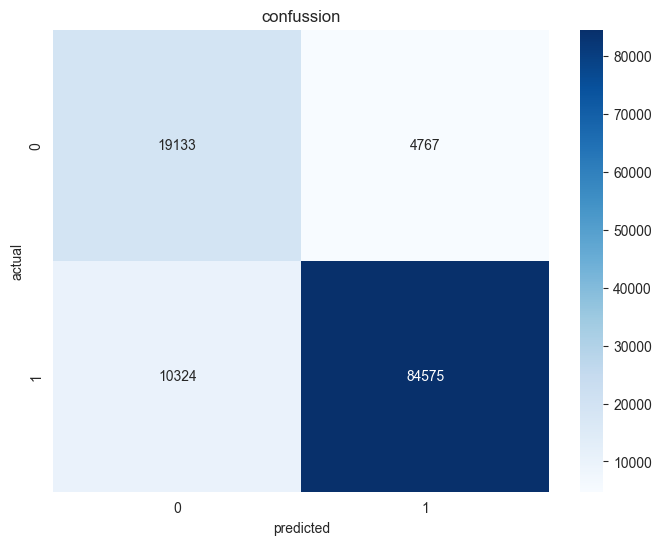

In [37]:
# 计算混淆矩阵
cm = confusion_matrix(valid[0][TARGET], (valid_tsp_compre > 0.5).astype(int))
print("混淆矩阵:")
print(cm)

# 可视化混淆矩阵
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('predicted')
plt.ylabel('actual')
plt.title('confussion')